# Machine Learning Lifecycle Project

## This is an exercise in 3 parts:
### A. Setup and Message Production
### B. Message Consumption and Storage
### C. Predictive Modeling with Machine Learning
$~$  
# C. Predictive Modeling with Machine Learning
$~$

# 1. Key Parameters

In [2713]:
#train the machine learning model?
train='no'
#if retraining, from what record number forward?
first_training_record=6001

#Note: always train initially!

# 2. Machine Learning Model

In [2714]:
#import packages
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score 
import sys, os
import json
from time import sleep
from kafka import KafkaConsumer
from kafka import KafkaProducer
import psycopg2
import pandas.io.sql as psql
%matplotlib inline

In [2715]:
#establish PostgreSQL database connection
conn_string = "host=localhost port=5432 dbname=messaging user=postgres password=postgres"
connection=psycopg2.connect(conn_string)
cursor = connection.cursor()
cursor.execute('SELECT version()')
db_version = cursor.fetchone()
print('PostgreSQL database version:',db_version)

PostgreSQL database version: ('PostgreSQL 11.2, compiled by Visual C++ build 1914, 64-bit',)


In [2716]:
#gather data and train ML model
if train=='yes':
    connection=psycopg2.connect(conn_string)
    
    #pull data to train model
    dfraw = pd.read_sql_query("SELECT * FROM rawdata", connection)
    dfraw = dfraw.set_index('key')
    dfresults = pd.read_sql_query("SELECT * FROM results", connection)
    dfresults = dfresults.set_index('key')
    dfsamples = dfraw.join(dfresults, how='inner')
    #limit data for retraining
    dfsamples = dfsamples.loc[dfsamples.index > first_training_record]
    dfsamples.columns=['x','y','class']

    #split X values from Y class
    X = dfsamples.iloc[:, :-1].values  
    Y = dfsamples.iloc[:,2].values

    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.40)

    #establish and fit KNN model
    k=15
    classifier = KNeighborsClassifier(n_neighbors=k)  
    classifier.fit(X_train, y_train)
    
    #make test predictions
    y_pred = classifier.predict(X_test)
    
else:
    print('no model retraining this pass')

no model retraining this pass


# 3. Train/Test Data Model Evaluation

In [2717]:
#TEST data model performance
#print(confusion_matrix(y_test, y_pred))  
print('Trained Model Test Data Accuracy Score :',accuracy_score(y_test, y_pred)*100)
testacc=accuracy_score(y_test, y_pred)
testrecall=recall_score(y_test, y_pred)
testprecision=precision_score(y_test, y_pred)
print(' ')
print(classification_report(y_test, y_pred))

Trained Model Test Data Accuracy Score : 96.125
 
              precision    recall  f1-score   support

       False       0.98      0.97      0.98       630
        True       0.89      0.94      0.91       170

   micro avg       0.96      0.96      0.96       800
   macro avg       0.94      0.95      0.94       800
weighted avg       0.96      0.96      0.96       800



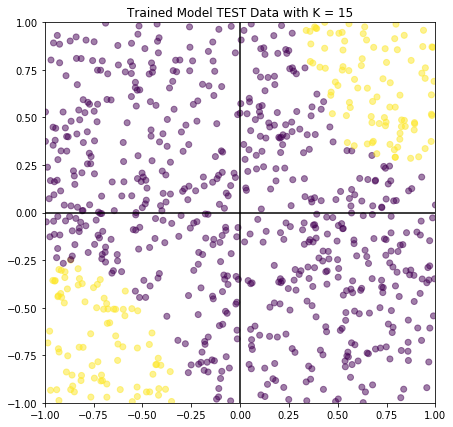

In [2718]:
#plot Training TEST data predictions
plt.figure(figsize=(7,7))
ax=plt.axes()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, facecolor='white', alpha=0.5)
ax.set_xlim(left=-1.0, right=1.0)
ax.set_ylim(bottom=-1.0, top=1.0)
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.title('Trained Model TEST Data with K = {}'.format(k))
plt.show()

# 4. K Validation

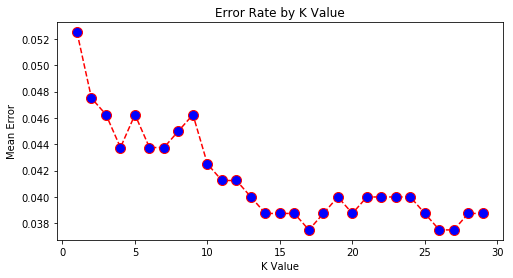

In [2719]:
#plot to validate choice of k
error = []
for i in range(1, 30):  
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(8, 4))
ax=plt.axes()
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
ax.set_facecolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
plt.title('Error Rate by K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  
plt.show()

# 5. Make Predictions for New Data

In [2720]:
#prepare data for new predictions
dfpredictions = pd.read_sql_query("SELECT * FROM predictions WHERE prediction is null", connection)
dfpredictions = dfpredictions.set_index('key')

dfraw = pd.read_sql_query("SELECT * FROM rawdata", connection)
dfraw = dfraw.set_index('key')

dfpredictions = dfraw.join(dfpredictions, how='inner')
dfpredictions.columns=['x','y','class']
del dfpredictions['class']

X_new = dfpredictions.iloc[:, :].values
print(dfpredictions.shape[0],"new records need class predictions")

5000 new records need class predictions


In [2721]:
#make predictions for new records
if dfpredictions.shape[0]>0:
    newpreds = classifier.predict(X_new).tolist()
    dfpredtemp = pd.DataFrame(newpreds, index=dfpredictions.index, columns=['prediction'])
    dfpredtemp.reset_index(inplace=True)
    print(dfpredtemp.shape[0],"predictions from trained model complete")
else:
    print("no new records to predict")

5000 predictions from trained model complete


# 6. Add Prediction Data to PostgreSQL

In [2722]:
#send predictions to PostgreSQL by creating temp table then updating from it
connection=psycopg2.connect(conn_string)
cursor = connection.cursor()
cursor.execute('DROP TABLE predtemp')
connection.commit()
cursor = connection.cursor()
cursor.execute('CREATE TABLE predtemp(Key INTEGER PRIMARY KEY, Prediction BOOLEAN)')
connection.commit()

for index, row in dfpredtemp.iterrows():
    cursor.execute('INSERT INTO predtemp (key, prediction) VALUES (%s,%s)', [row['key'],row['prediction']])
    connection.commit()

cursor = connection.cursor()
cursor.execute('UPDATE predictions SET prediction = predtemp.prediction FROM predtemp WHERE predtemp.key = predictions.key')
connection.commit()

print(dfpredtemp.shape[0],"predictions inserted successfully into database")
dfpredtemp = dfpredtemp[0:0]

5000 predictions inserted successfully into database


# 7. All Data Model Evaluation

In [2723]:
#organize ALL data for plotting
rawdf = psql.read_sql("SELECT * FROM rawdata", connection)
resultsdf = psql.read_sql("SELECT * FROM results", connection)
plotdf = pd.merge(rawdf, resultsdf, on='key', how='inner')
predsdf = psql.read_sql("SELECT * FROM predictions", connection)
plotdf = pd.merge(plotdf, predsdf, on='key', how='inner')
plotdf['correct'] = (plotdf['result'] == plotdf['prediction']).astype(int)
plotdf['correctandpredtrue'] = ((plotdf['correct'] == 1) & (plotdf['prediction'] == True)).astype(int)
#plotdf[:5]

In [2733]:
#ALL data model performance
#print(confusion_matrix(y_test, y_pred))  
print('Trained Model ALL Data Accuracy Score :',accuracy_score(plotdf['result'], plotdf['prediction'])*100)
modelacc=accuracy_score(plotdf['result'], plotdf['prediction'])
print(' ')
print(classification_report(plotdf['result'], plotdf['prediction']))

[[610  20]
 [ 11 159]]
Trained Model ALL Data Accuracy Score : 89.86153846153846
 
              precision    recall  f1-score   support

       False       0.94      0.91      0.92      8621
        True       0.83      0.89      0.85      4379

   micro avg       0.90      0.90      0.90     13000
   macro avg       0.88      0.90      0.89     13000
weighted avg       0.90      0.90      0.90     13000



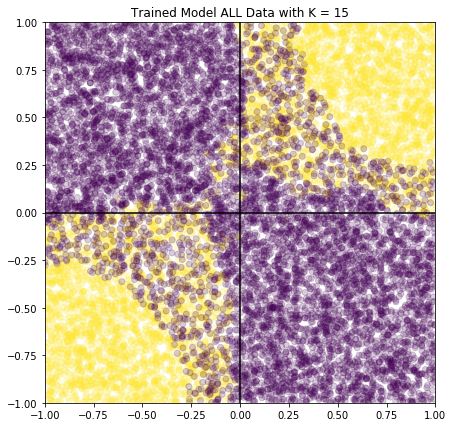

In [2734]:
#ALL data prediction plot
plt.figure(figsize=(7,7))
ax=plt.axes()
plt.scatter(plotdf['x'], plotdf['y'], c=plotdf['prediction'], facecolor='white', alpha=0.2)
ax.set_xlim(left=-1.0, right=1.0)
ax.set_ylim(bottom=-1.0, top=1.0)
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.title('Trained Model ALL Data with K = {}'.format(k))
plt.show()

# 8. Plot of Correct Predictions 

In [2726]:
#create model performance data
x=[]
y=[]
z=[]
q=[]
t=[]
count=0
correct=0
countpredtrue=0.001
correctandpredtrue=0
true=.001
for index, row in plotdf.iterrows():
    count=count+1
    x.append(count)
    correct=correct + row['correct']
    y.append(correct)
    countpredtrue=countpredtrue + row['prediction']
    q.append(countpredtrue)
    correctandpredtrue=correctandpredtrue + row['correctandpredtrue']
    z.append(correctandpredtrue)
    true=true + row['result']
    t.append(true)
#print(count,correct,countpredtrue,correctandpredtrue,true)

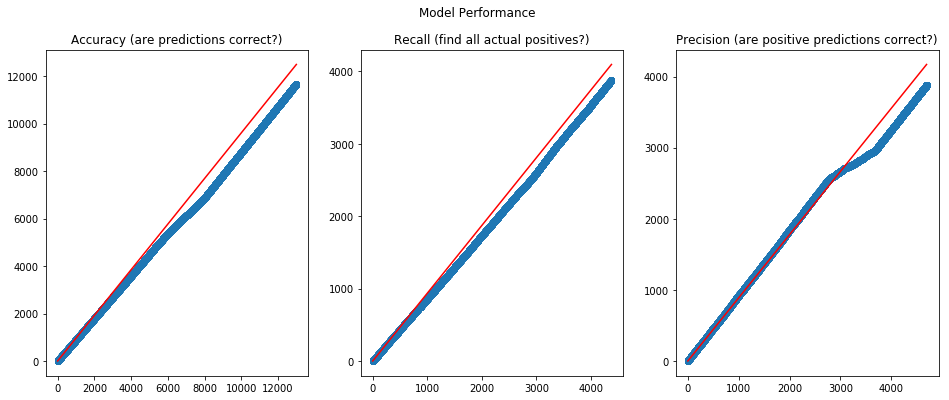

In [2727]:
#create model performance plots
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex='none', figsize=(16,6))
f.suptitle('Model Performance')
ax1.set_title('Accuracy (are predictions correct?)')
ax1.scatter(x,y)
ax1.plot([0, count], [0, count*testacc],'k-', color = 'r')

ax2.set_title('Recall (find all actual positives?)')
ax2.scatter(t,z)
ax2.plot([0, true], [0, true*testrecall],'k-', color = 'r')

ax3.set_title('Precision (are positive predictions correct?)')
ax3.scatter(q,z)
ax3.plot([0, countpredtrue], [0, countpredtrue*testprecision],'k-', color = 'r')

### PostgreSQL Utility Code

In [2728]:
#close connection
#cursor.close()
#connection.close()
#print("PostgreSQL connection is closed")

In [2729]:
#clear all table records
#cursor = connection.cursor()
#cursor.execute(""" DELETE FROM rawdata""")
#cursor.execute(""" DELETE FROM results""")
#cursor.execute(""" DELETE FROM predictions""")
#cursor.execute(""" DELETE FROM predtemp""")
#connection.commit()

In [2730]:
#cursor = connection.cursor()
#cursor.execute("CREATE TABLE predtemp(Key INTEGER PRIMARY KEY, Prediction BOOLEAN)")
#cursor.execute("DROP TABLE predtemp")
#connection.commit()

In [2731]:
#rollback on error break
#cursor = connection.cursor()
#cursor.execute("rollback;")

In [2732]:
#select * from predictions order by key desc limit 12;